In [1]:
import rasterio
import numpy as np
from glob import glob
from pathlib import Path
import os
from tifffile import imread
from matplotlib import pyplot as plt

import xarray as xr 
import rioxarray as rio 

from osgeo import gdal
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
from rasterio.mask import mask
from rasterio.plot import show

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

def read_file(file):
    with rasterio.open(file) as src:
        return(src.read(1))
    
bbox_original = box(-180.0,60.0,180.0,90.0)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def repr(filename, output_raster, wkt):
    input_raster = gdal.Open(filename)
    gdal.SetConfigOption('GDAL_NUM_THREADS', '4')
    warp = gdal.Warp(output_raster,input_raster,dstSRS=wkt, xRes = 4000, yRes = 4000)
    warp = None # Closes the files

In [3]:
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import glob
from shapely.geometry import mapping
cavm_path = "/home/cluster/eplekh/data/cavm/shape/cp_veg_la.shp"
crop_extent = gpd.read_file(cavm_path)
wkt = "+proj=laea +lat_0=90 +lon_0=180 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

nc_folder = '/home/cluster/eplekh/scratch/climate_data/15Jul/0.1deg/'
nc_files = os.listdir(nc_folder)

In [4]:
nc_files

['rsds_15JUL_CNRM-ESM2-1_2000-2014_0.1x0.1.nc',
 'rsds_15JUL_IPSL-CM6A-LR_2000-2014_0.1x0.1.nc',
 'snc_15JUL_IPSL-CM6A-LR_2000-2014_0.1x0.1.nc',
 'rsus_15JUL_EC-Earth3-Veg_2000-2014_0.1x0.1.nc',
 'rsus_15JUL_MIROC6_2000-2014_0.1x0.1.nc',
 'snc_15JUL_EC-Earth3-Veg_2000-2014_0.1x0.1.nc',
 'rsus_15JUL_IPSL-CM6A-LR_2000-2014_0.1x0.1.nc',
 'rsds_15JUL_EC-Earth3-Veg_2000-2014_0.1x0.1.nc',
 'rsus_15JUL_CNRM-CM6-1_2000-2014_0.1x0.1.nc',
 'rsus_15JUL_CNRM-ESM2-1_2000-2014_0.1x0.1.nc',
 'rsds_15JUL_MIROC6_2000-2014_0.1x0.1.nc',
 'snc_15JUL_CNRM-ESM2-1_2000-2014_0.1x0.1.nc',
 'snc_15JUL_UKESM1-0-LL_2000-2014_0.1x0.1.nc',
 'snc_15JUL_MIROC6_2000-2014_0.1x0.1.nc',
 'snc_15JUL_CNRM-CM6-1_2000-2014_0.1x0.1.nc',
 'rsus_15JUL_UKESM1-0-LL_2000-2014_0.1x0.1.nc',
 'rsds_15JUL_CNRM-CM6-1_2000-2014_0.1x0.1.nc',
 'rsds_15JUL_UKESM1-0-LL_2000-2014_0.1x0.1.nc']

In [57]:
nc_file = xr.open_dataset(nc_folder + nc_files[2])
bt = nc_file[nc_files[2].split("_")[0]]
bt

<xarray.DataArray 'snc' (time: 15, lat: 340, lon: 3600)>
[18360000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-07-14T12:00:00 ... 2014-07-15T12:00:00
  * lon      (lon) float32 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
  * lat      (lat) float32 66.0 66.1 66.2 66.3 66.4 ... 99.5 99.6 99.7 99.8 99.9
Attributes:
    standard_name:       surface_snow_area_fraction
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 d
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

In [58]:
for NCF in nc_files:
    nc_file = xr.open_dataset(nc_folder + NCF)
    bt = nc_file[NCF.split("_")[0]]
    yrs = [int(str(el)[:4]) for el in np.array(nc_file.time)]
    for yr in range(2000, 2015):
        jl = bt[[str(yr) == v[:4] for v in bt.time.values.astype(str)]]
        jl = jl.drop("time")
        jl.coords['lon'] = (jl.coords['lon'] + 180) % 360 - 180
        jl = jl.sortby(jl.lon)
        jl = jl.rio.set_spatial_dims('lon', 'lat')
        jl.rio.set_crs("epsg:4326")
        modname = NCF.split("JUL_")[1][:8]
        pth_f = "/home/cluster/eplekh/scratch/climate_data/15Jul/0.1/tiffs/" + modname + "/"
        Path(pth_f).mkdir(parents=True, exist_ok=True)
        pth = pth_f +str(yr) + "_" + modname + "_" + NCF[:4]+".tiff"
        jl.rio.to_raster(pth)
        repr(pth, pth, wkt)
        im = rxr.open_rasterio(pth, masked=True).squeeze()
        im_clipped = im.rio.clip(crop_extent.geometry.apply(mapping), crop_extent.crs)
        im_clipped.rio.to_raster(pth)

In [ ]:
nc_file = xr.open_dataset(nc_folder + nc_files[0])
bt = nc_file[nc_files[0][:4]]
yrs = [int(str(el)[:4]) for el in np.array(nc_file.time)]
for yr in range(2000, 2015):
    jl = bt[[str(yr) == v[:4] for v in bt.time.values.astype(str)]]
    jl = jl.drop("time")
    jl.coords['lon'] = (jl.coords['lon'] + 180) % 360 - 180
    jl = jl.sortby(jl.lon)
    jl = jl.rio.set_spatial_dims('lon', 'lat')
    jl.rio.set_crs("epsg:4326")
    modname = nc_files[0].split("JUL_")[1][:8]
    pth_f = "/home/cluster/eplekh/scratch/climate_data/15Jul/0.1/tiffs/" + modname + "/"
    Path(pth_f).mkdir(parents=True, exist_ok=True)
    pth = pth_f +str(yr) + "_" + modname + "_" + nc_files[0][:4]+".tiff"
    jl.rio.to_raster(pth)
    repr(pth, pth, wkt)
    im = rxr.open_rasterio(pth, masked=True).squeeze()
    im_clipped = im.rio.clip(crop_extent.geometry.apply(mapping), crop_extent.crs)
    im_clipped.rio.to_raster(pth)

In [12]:
im = rxr.open_rasterio(pth, masked=True).squeeze()
im_clipped = im.rio.clip(crop_extent.geometry.apply(mapping), crop_extent.crs)
im_clipped.rio.to_raster(pth)

In [22]:
nc_file

<xarray.Dataset>
Dimensions:    (time: 15, bnds: 2, lon: 3600, lat: 340)
Coordinates:
  * time       (time) object 2000-07-16 12:00:00 ... 2014-07-16 12:00:00
  * lon        (lon) float32 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * lat        (lat) float32 66.0 66.1 66.2 66.3 66.4 ... 99.6 99.7 99.8 99.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    rsds       (time, lat, lon) float32 ...
Attributes: (12/48)
    CDI:                     Climate Data Interface version 1.9.2 (http://mpi...
    history:                 Wed Jan 19 15:49:53 2022: cdo remapbil,mygrid.tx...
    source:                  CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3...
    institution:             Fondazione Centro Euro-Mediterraneo sui Cambiame...
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             LS3MIP LUMIP
    ...                      ...
    license:                 CMIP6 model data produced by CMCC is licensed un...
    cmor_version:            3.5.0
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CMCC.CMCC-E...
    source_id:               CMCC-ESM2
    title:                   CMCC-ESM2 output prepared for CMIP6
    CDO:                     Climate Data Operators version 1.9.2 (http://mpi...

In [9]:
nc_files

['rsus_JUL_MIROC6_2000-2014_0.1x0.1.nc',
 'rsds_JUL_CMCC-ESM2_2000-2014_0.1x0.1.nc',
 'rsus_JUL_GISS-E2-1-G_2000-2014_0.1x0.1.nc',
 'rsus_JUL_UKESM1-0-LL_2000-2014_0.1x0.1.nc',
 'rsus_JUL_EC-Earth3-Veg_2000-2014_0.1x0.1.nc',
 'rsds_JUL_CNRM-ESM2-1_2000-2014_0.1x0.1.nc',
 'rsus_JUL_IPSL-CM6A-LR_2000-2014_0.1x0.1.nc',
 'rsus_JUL_CESM2_2000-2014_0.1x0.1.nc',
 'rsds_JUL_CESM2_2000-2014_0.1x0.1.nc',
 'rsds_JUL_IPSL-CM6A-LR_2000-2014_0.1x0.1.nc',
 'rsds_JUL_MIROC6_2000-2014_0.1x0.1.nc',
 'rsus_JUL_CNRM-CM6-1_2000-2014_0.1x0.1.nc',
 'rsds_JUL_E3SM-1-1_2000-2014_0.1x0.1.nc',
 'rsds_JUL_UKESM1-0-LL_2000-2014_0.1x0.1.nc',
 'rsus_JUL_CMCC-ESM2_2000-2014_0.1x0.1.nc',
 'rsds_JUL_EC-Earth3-Veg_2000-2014_0.1x0.1.nc',
 'rsus_JUL_CNRM-ESM2-1_2000-2014_0.1x0.1.nc',
 'rsds_JUL_CNRM-CM6-1_2000-2014_0.1x0.1.nc',
 'rsds_JUL_GISS-E2-1-G_2000-2014_0.1x0.1.nc',
 'rsus_JUL_E3SM-1-1_2000-2014_0.1x0.1.nc']

In [ ]:
for i in range(0, len(nc_files)):
    nc_file = xr.open_dataset(nc_folder + nc_files[i])
    bt = nc_file[nc_files[i][:4]]
    yrs = [int(str(el)[:4]) for el in np.array(nc_file.time)]
    
    for k,yr in enumerate(yrs):
        jl = bt[k,:,:]
        jl = jl.drop("time")
        jl.coords['lon'] = (jl.coords['lon'] + 180) % 360 - 180
        jl = jl.sortby(jl.lon)
        jl = jl.rio.set_spatial_dims('lon', 'lat')
        jl.rio.set_crs("epsg:4326")
        modname = nc_files[i].split("JUL_")[1][:8]
        pth_f = "/home/cluster/eplekh/scratch/climate_data/0.1/tiffs/" + modname + "/"
        Path(pth_f).mkdir(parents=True, exist_ok=True)
        pth = pth_f +str(yr) + "_" + modname + "_" + nc_files[i][:4]+".tiff"
        jl.rio.to_raster(pth)
        repr(pth, pth, wkt)
        im = rxr.open_rasterio(pth, masked=True).squeeze()
        im_clipped = im.rio.clip(crop_extent.geometry.apply(mapping), crop_extent.crs)
        im_clipped.rio.to_raster(pth)

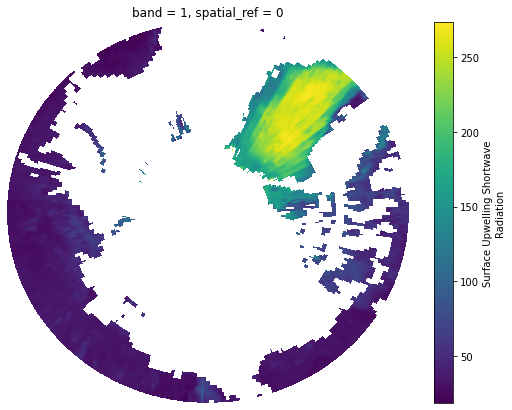

In [26]:
img = rio.open_rasterio(pth,
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(9, 7))
img.plot.imshow()
ax.set_axis_off()
plt.show()

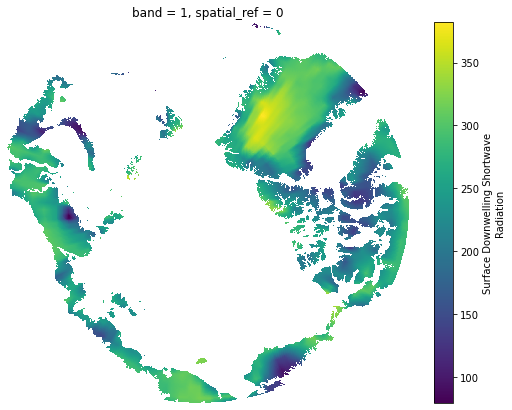

In [51]:
img = rio.open_rasterio("/home/cluster/eplekh/scratch/climate_data/15Jul/0.1/tiffs/CNRM-ESM/2000_CNRM-ESM_rsds.tiff",
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(9, 7))
img.plot.imshow()
ax.set_axis_off()
plt.show()

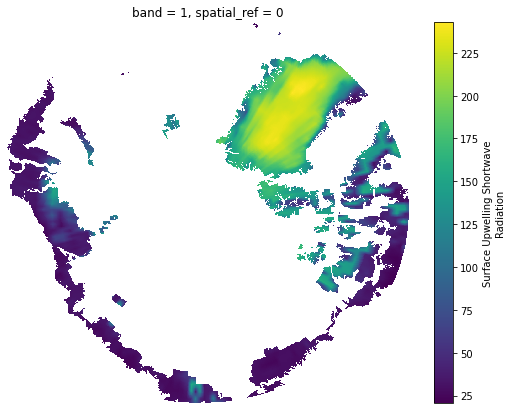

In [29]:
img = rio.open_rasterio("/home/cluster/eplekh/scratch/climate_data/0.1/tiffs/2000_CMCC-ESM_rsus.tiff",
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(9, 7))
img.plot.imshow()
ax.set_axis_off()
plt.show()

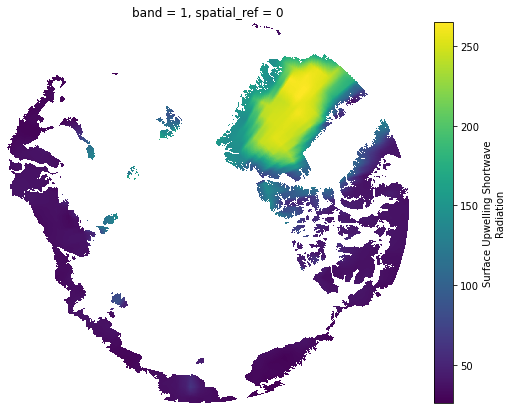

In [32]:
img = rio.open_rasterio("/home/cluster/eplekh/scratch/climate_data/0.1/tiffs/2000_CNRM-CM6_rsus.tiff",
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(9, 7))
img.plot.imshow()
ax.set_axis_off()
plt.show()

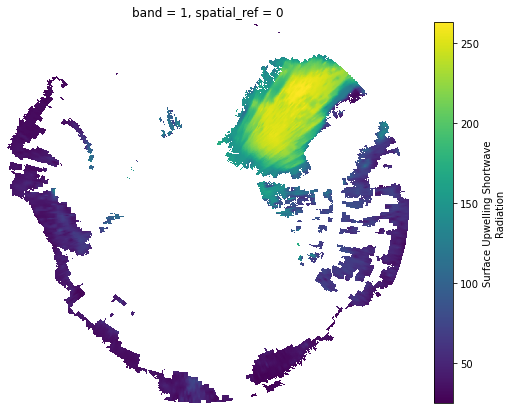

In [33]:
img = rio.open_rasterio("/home/cluster/eplekh/scratch/climate_data/0.1/tiffs/2000_E3SM-1-1_rsus.tiff",
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(9, 7))
img.plot.imshow()
ax.set_axis_off()
plt.show()

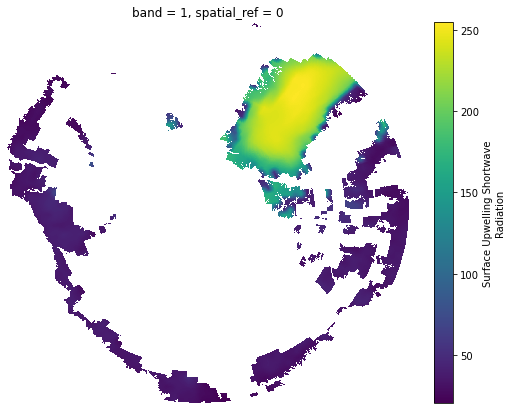

In [34]:
img = rio.open_rasterio("/home/cluster/eplekh/scratch/climate_data/0.1/tiffs/2000_EC-Earth_rsus.tiff",
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(9, 7))
img.plot.imshow()
ax.set_axis_off()
plt.show()

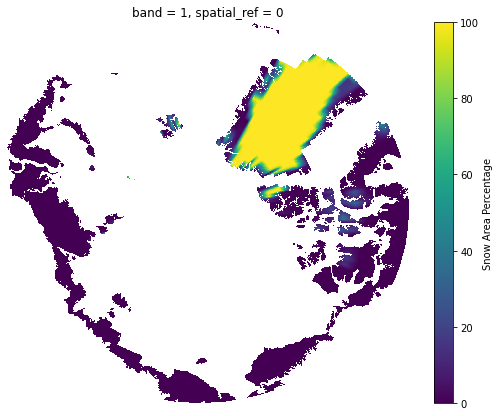

In [60]:
img = rio.open_rasterio("/home/cluster/eplekh/scratch/climate_data/15Jul/0.1/tiffs/MIROC6_2/2000_MIROC6_2_snc_.tiff",
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(9, 7))
img.plot.imshow()
ax.set_axis_off()
plt.show()

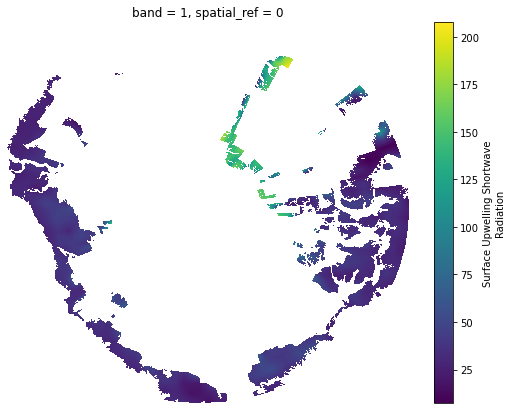

In [36]:
img = rio.open_rasterio("/home/cluster/eplekh/scratch/climate_data/0.1/tiffs/2000_IPSL-CM6_rsus.tiff",
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(9, 7))
img.plot.imshow()
ax.set_axis_off()
plt.show()

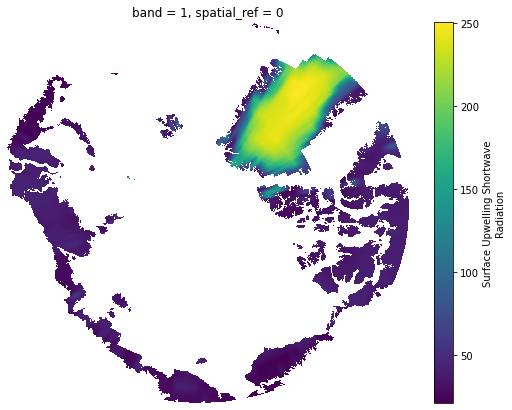

In [39]:
img = rio.open_rasterio("/home/cluster/eplekh/scratch/climate_data/0.1/tiffs/2000_MIROC6_2_rsus.tiff",
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(9, 7))
img.plot.imshow()
ax.set_axis_off()
plt.show()